In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from autogluon.tabular import TabularPredictor
from sklearn.metrics import  mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [5]:
# --- 1. 데이터 불러오기 & 기본 전처리 ---
df = pd.read_csv('/content/gdrive/MyDrive/train_heat.csv', encoding='CP949')
df = df.replace(-99, np.nan).drop(columns='Unnamed: 0')
#코드 다돌리고 추가1
df['train_heat.wd'] = df['train_heat.wd'].replace(-9.9, np.nan)
# 시간 전처리
df['month'] = df['train_heat.tm'].astype(str).str[4:6].astype(int)
df['hour'] = df['train_heat.tm'].astype(str).str[8:10].astype(int)
df['date'] = pd.to_datetime(df['train_heat.tm'].astype(str).str[:8])
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['train_heat.tm'] = pd.to_datetime(df['train_heat.tm'].astype(str), format='%Y%m%d%H')
df = df.sort_values('train_heat.tm').set_index('train_heat.tm')

# 결측치 선형보간
for col in df.columns[df.isnull().any()]:
    df[col] = df[col].interpolate(method='linear')

# --- 2. 파생변수 생성 (기존 + 추가) ---

# 계절 구분
df['heating_season'] = df['month'].apply(lambda x: 1 if x in [10, 11, 12, 1, 2, 3, 4] else 0)
df['temp_category'] = df['train_heat.ta'].apply(lambda x: 1 if x >= 20 else 0)

def peak_time_category(hour):
    if 0 <= hour <= 6:
        return 0  # 심야
    elif 6 < hour <= 11:
        return 1  # 오전
    elif 11 < hour <= 18:
        return 2  # 오후
    else:
        return 3  # 저녁

df['peak_time'] = df['hour'].apply(peak_time_category)

# lag
for lag in [1, 2, 3]:
    df[f'ta_lag_{lag}'] = df['train_heat.ta'].shift(lag).interpolate(method='linear')

# HDD, CDD
base_temp = 18.0
df['HDD'] = (base_temp - df['train_heat.ta']).clip(lower=0)
df['CDD'] = (df['train_heat.ta'] - base_temp).clip(lower=0)

# 편차
df['branch_temp_abs_deviation'] = (
    df['train_heat.ta'] - df.groupby('train_heat.branch_id')['train_heat.ta'].transform('mean')
).abs()

# ========== [추천 파생변수 추가] ==========

# 변수별 변화량(diff) 및 24시간 이동평균
for var in ['train_heat.ta', 'train_heat.si', 'train_heat.ta_chi', 'train_heat.ws', 'train_heat.wd', 'train_heat.rn_day', 'train_heat.rn_hr1', 'train_heat.heat_demand']:
    if var in df.columns:
        df[f'{var}_diff'] = df[var].diff().fillna(0)
        df[f'{var}_ma24'] = df[var].rolling(window=24, min_periods=1).mean()

# 누적 강수량(최근 3/6/12/24시간)
for h in [3, 6, 12, 24]:
    if 'train_heat.rn_hr1' in df.columns:
        df[f'train_heat.rn_hr1_sum{h}'] = df['train_heat.rn_hr1'].rolling(h, min_periods=1).sum()

# 최고/최저 기온(최근 6/12/24시간)
for h in [6, 12, 24]:
    if 'train_heat.ta' in df.columns:
        df[f'train_heat.ta_max{h}'] = df['train_heat.ta'].rolling(h, min_periods=1).max()
        df[f'train_heat.ta_min{h}'] = df['train_heat.ta'].rolling(h, min_periods=1).min()

# 체감온도-실제온도 차
if 'train_heat.ta_chi' in df.columns and 'train_heat.ta' in df.columns:
    df['diff_ta_chi'] = df['train_heat.ta_chi'] - df['train_heat.ta']

# 풍속 급변(2-step 차분)
if 'train_heat.ws' in df.columns:
    df['ws_diff2'] = df['train_heat.ws'].diff(2).fillna(0)

# 당일 누적 강수량
if 'train_heat.rn_day' in df.columns:
    df['rn_day_cumsum'] = df['train_heat.rn_day'].cumsum()

# 전일 평균/최고/최저 기온
if 'train_heat.ta' in df.columns:
    df['ta_yesterday_avg'] = df['train_heat.ta'].shift(24).rolling(24).mean()
    df['ta_yesterday_max'] = df['train_heat.ta'].shift(24).rolling(24).max()
    df['ta_yesterday_min'] = df['train_heat.ta'].shift(24).rolling(24).min()

# 임계치 이탈 플래그
if 'train_heat.ta' in df.columns:
    df['cold_flag'] = (df['train_heat.ta'] < 5).astype(int)
    df['hot_flag'] = (df['train_heat.ta'] > 25).astype(int)

# ========== [겹치지 않는 추가 파생변수 아이디어] ==========

# 1. 최근 3시간 평균/최대/최소 열수요 (수요 패턴 반영)
df['heat_demand_ma3'] = df['train_heat.heat_demand'].rolling(3, min_periods=1).mean()
df['heat_demand_max3'] = df['train_heat.heat_demand'].rolling(3, min_periods=1).max()
df['heat_demand_min3'] = df['train_heat.heat_demand'].rolling(3, min_periods=1).min()

# 2. 전주 같은 시간대 열수요 (주기성 반영)
df['heat_demand_lastweek'] = df['train_heat.heat_demand'].shift(24*7)

# 3. 시간대별 평균 열수요와의 차이 (이상치 탐지, 패턴 반영)
df['hourly_avg_heat_demand'] = df.groupby('hour')['train_heat.heat_demand'].transform('mean')
df['heat_demand_hourly_dev'] = df['train_heat.heat_demand'] - df['hourly_avg_heat_demand']

# 4. 전일 동시간대 열수요
df['heat_demand_yesterday'] = df['train_heat.heat_demand'].shift(24)

# 5. 최근 6시간 기온 표준편차 (기온 변동성)
df['ta_std6'] = df['train_heat.ta'].rolling(6, min_periods=1).std().fillna(0)

# 6. 최근 6시간 풍속 표준편차 (풍속 변동성)
df['ws_std6'] = df['train_heat.ws'].rolling(6, min_periods=1).std().fillna(0)

# 7. 최근 24시간 내 강수 발생 여부 (이진 플래그)
df['rain_flag_24h'] = (df['train_heat.rn_hr1'].rolling(24, min_periods=1).sum() > 0).astype(int)

# 8. 월별 평균 기온과의 차이 (계절적 이상치)
df['monthly_avg_ta'] = df.groupby('month')['train_heat.ta'].transform('mean')
df['ta_monthly_dev'] = df['train_heat.ta'] - df['monthly_avg_ta']

# 9. 주말/평일 플래그 (is_weekend는 이미 있음, is_holiday는 없으므로 주말만)
# 이미 is_weekend 있음

# 10. 최근 12시간 열수요 증가폭 (트렌드)
df['heat_demand_trend12'] = df['train_heat.heat_demand'] - df['train_heat.heat_demand'].shift(12)

# --- 3. 학습 및 평가용 Walk-Forward 구조 ---
target = 'train_heat.heat_demand'
# 새로 추가된 파생변수도 features에 포함
features = [
    "train_heat.branch_id", "train_heat.ta", "train_heat.wd", "train_heat.ws", "train_heat.rn_day",
    "train_heat.rn_hr1", "train_heat.hm", "train_heat.si", "train_heat.ta_chi",
    "month", "weekday", "heating_season", "temp_category", "peak_time", "is_weekend",
    "ta_lag_1", "ta_lag_2", "ta_lag_3", "HDD", "CDD", "branch_temp_abs_deviation",
    # 기존 diff/ma24
    "train_heat.ta_diff", "train_heat.ta_ma24", "train_heat.si_diff", "train_heat.si_ma24",
    "train_heat.ta_chi_diff", "train_heat.ta_chi_ma24", "train_heat.ws_diff", "train_heat.ws_ma24",
    "train_heat.wd_diff", "train_heat.wd_ma24", "train_heat.rn_day_diff", "train_heat.rn_day_ma24",
    "train_heat.rn_hr1_diff", "train_heat.rn_hr1_ma24", "train_heat.heat_demand_diff", "train_heat.heat_demand_ma24",
    # 누적 강수량
    "train_heat.rn_hr1_sum3", "train_heat.rn_hr1_sum6", "train_heat.rn_hr1_sum12", "train_heat.rn_hr1_sum24",
    # 최고/최저 기온
    "train_heat.ta_max6", "train_heat.ta_max12", "train_heat.ta_max24",
    "train_heat.ta_min6", "train_heat.ta_min12", "train_heat.ta_min24",
    # 체감온도-실제온도 차, 풍속 급변, 누적 강수량, 전일 기온, 임계치 플래그
    "diff_ta_chi", "ws_diff2", "rn_day_cumsum",
    "ta_yesterday_avg", "ta_yesterday_max", "ta_yesterday_min",
    "cold_flag", "hot_flag",
    # 추가 파생변수
    "heat_demand_ma3", "heat_demand_max3", "heat_demand_min3",
    "heat_demand_lastweek", "heat_demand_hourly_dev", "heat_demand_yesterday",
    "ta_std6", "ws_std6", "rain_flag_24h", "ta_monthly_dev", "heat_demand_trend12"
]
categorical_cols = [
    "train_heat.branch_id", "month", "weekday", "heating_season", "temp_category", "peak_time", "is_weekend",
    "cold_flag", "hot_flag", "rain_flag_24h"
]

# 풍향이 범주형이면 추가
if df['train_heat.wd'].nunique() < 20:
    categorical_cols.append("train_heat.wd")



#코드 다 돌리고 추가2
#전처리마지막에 결측치
for col in df.columns[df.isnull().any()]:
    df[col] = df[col].interpolate(method='linear')
for col in df.columns[df.isnull().any()]:
    df[col] = df[col].fillna(0)



In [6]:
# 1. train/val/test 분할
df_trainval = df[df['date'].dt.year.isin([2021, 2022])].reset_index(drop=True)
df_test = df[df['date'].dt.year == 2023].reset_index(drop=True)

# 2. Walk-Forward (TimeSeriesSplit) 설정
n_splits = 5  # fold 개수는 데이터 크기에 따라 조정
tscv = TimeSeriesSplit(n_splits=n_splits)

results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_trainval)):
    print(f"\n===== Fold {fold+1} =====")
    df_train = df_trainval.iloc[train_idx].copy()
    df_val = df_trainval.iloc[val_idx].copy()

    # 인코딩
    df_train_encoded = pd.get_dummies(df_train[features + [target]], columns=categorical_cols)
    df_val_encoded = pd.get_dummies(df_val[features + [target]], columns=categorical_cols)
    df_test_encoded = pd.get_dummies(df_test[features + [target]], columns=categorical_cols)

    # 열 맞추기
    df_val_encoded = df_val_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)
    df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)

    # 스케일링
    features_encoded = [col for col in df_train_encoded.columns if col != target]
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(df_train_encoded[features_encoded])
    X_val_scaled = scaler.transform(df_val_encoded[features_encoded])
    X_test_scaled = scaler.transform(df_test_encoded[features_encoded])

    df_train_scaled = pd.DataFrame(X_train_scaled, columns=features_encoded)
    df_train_scaled[target] = df_train_encoded[target].values

    df_val_scaled = pd.DataFrame(X_val_scaled, columns=features_encoded)
    df_val_scaled[target] = df_val_encoded[target].values

    df_test_scaled = pd.DataFrame(X_test_scaled, columns=features_encoded)
    df_test_scaled[target] = df_test_encoded[target].values

    # AutoGluon 학습 (train/val)
    predictor = TabularPredictor(
    label=target,
    problem_type='regression',
    path=f"AutogluonModels_fold{fold+1}"
    ).fit(
    train_data=df_train_scaled,
    tuning_data=df_val_scaled,
    presets='best_quality',
    use_bag_holdout=True,
    ag_args_fit={'num_gpus': 1}#코드 다돌리고 추가3
    )

    # 검증셋 평가
    y_val_true = df_val_scaled[target]
    y_val_pred = predictor.predict(df_val_scaled[features_encoded])
    val_rmse = mean_squared_error(y_val_true, y_val_pred) ** 0.5

    # 테스트셋 평가 (2023)
    y_test_true = df_test_scaled[target]
    y_test_pred = predictor.predict(df_test_scaled[features_encoded])
    test_rmse = mean_squared_error(y_test_true, y_test_pred) ** 0.5

    print(f"Fold {fold+1} | Val RMSE: {val_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

    results.append({
        'fold': fold+1,
        'val_rmse': val_rmse,
        'test_rmse': test_rmse
    })

# 결과 DataFrame
results_df = pd.DataFrame(results)
print("\n===== 전체 Fold 결과 =====")
print(results_df)


===== Fold 1 =====


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          12
Memory Avail:       80.15 GB / 83.48 GB (96.0%)
Disk Space Avail:   193.17 GB / 235.68 GB (82.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/content/AutogluonModels_fold1"
Train Data Rows:    55481
Train Data Columns: 103
Tuning Data Rows:    55476
Tuning Data Columns: 103
Label Column:       train_heat.heat_demand
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the

Fold 1 | Val RMSE: 3.6904 | Test RMSE: 6.1827

===== Fold 2 =====


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          12
Memory Avail:       74.55 GB / 83.48 GB (89.3%)
Disk Space Avail:   189.27 GB / 235.68 GB (80.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/content/AutogluonModels_fold2"
Train Data Rows:    110957
Train Data Columns: 107
Tuning Data Rows:    55476
Tuning Data Columns: 107
Label Column:       train_heat.heat_demand
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess th

Fold 2 | Val RMSE: 3.1080 | Test RMSE: 3.0315

===== Fold 3 =====


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          12
Memory Avail:       72.51 GB / 83.48 GB (86.9%)
Disk Space Avail:   186.29 GB / 235.68 GB (79.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/content/AutogluonModels_fold3"
Train Data Rows:    166433
Train Data Columns: 110
Tuning Data Rows:    55476
Tuning Data Columns: 110
Label Column:       train_heat.heat_demand
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess th

Fold 3 | Val RMSE: 3.2383 | Test RMSE: 2.9354

===== Fold 4 =====


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          12
Memory Avail:       72.02 GB / 83.48 GB (86.3%)
Disk Space Avail:   183.93 GB / 235.68 GB (78.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/content/AutogluonModels_fold4"
Train Data Rows:    221909
Train Data Columns: 110
Tuning Data Rows:    55476
Tuning Data Columns: 110
Label Column:       train_heat.heat_demand
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess th

Fold 4 | Val RMSE: 1.8693 | Test RMSE: 2.3416

===== Fold 5 =====


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          12
Memory Avail:       73.54 GB / 83.48 GB (88.1%)
Disk Space Avail:   182.17 GB / 235.68 GB (77.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/content/AutogluonModels_fold5"
Train Data Rows:    277385
Train Data Columns: 110
Tuning Data Rows:    55476
Tuning Data Columns: 110
Label Column:       train_heat.heat_demand
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess th

Fold 5 | Val RMSE: 2.3903 | Test RMSE: 2.2346

===== 전체 Fold 결과 =====
   fold  val_rmse  test_rmse
0     1  3.690414   6.182712
1     2  3.107984   3.031546
2     3  3.238282   2.935401
3     4  1.869292   2.341616
4     5  2.390270   2.234618


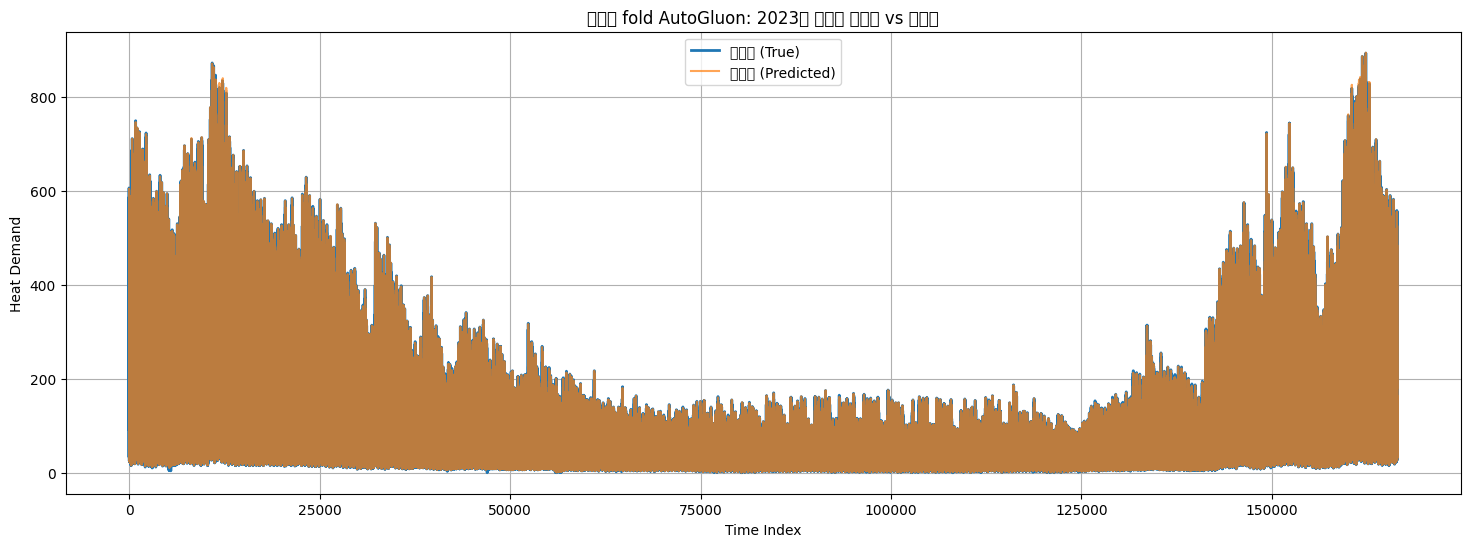

In [16]:
# fold loop 끝난 뒤, 마지막 fold의 predictor와 df_test_scaled, features_encoded, target 사용
y_test_true = df_test_scaled[[target]]


plt.figure(figsize=(18, 6))
plt.plot(y_test_true.values, label='실제값 (True)', linewidth=2)
plt.plot(y_test_pred.values.ravel(), label='예측값 (Predicted)', alpha=0.7)
# 또는
# plt.plot(y_test_pred.squeeze(), label='예측값 (Predicted)', alpha=0.7)
plt.title('마지막 fold AutoGluon: 2023년 열수요 예측값 vs 실제값')
plt.xlabel('Time Index')
plt.ylabel('Heat Demand')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#체감온도 직접만든 변수
def calc_wind_chill(Ta, RH, WS):
    # 겨울철 조건: 기온 10℃ 이하, 풍속 1.3m/s 이상
    cond = (Ta <= 10) & (WS >= 1.3)
    Tw = np.full_like(Ta, np.nan, dtype=np.float64)
    # 공식 적용
    Ta_ = Ta[cond]
    RH_ = RH[cond]
    WS_ = WS[cond]
    # 공식 (수정된 식)
    Tw_calc = (
        Ta_ * np.arctan(0.151977 * np.sqrt(RH_ + 8.313659))
        + np.arctan(Ta_ + RH_)
        - np.arctan(RH_ - 1.67633)
        + 0.00391838 * RH_ ** 1.5 * np.arctan(0.023101 * RH_)
        - 4.686035
    )
    # 겨울형 기간 동안 산출된 체감온도가 기온보다 높으면 기온과 같게
    Tw_calc = np.where(Tw_calc > Ta_, Ta_, Tw_calc)
    Tw[cond] = Tw_calc
    return Tw

# 적용
df['ta_chi_formula'] = calc_wind_chill(df['train_heat.ta'].values, df['train_heat.hm'].values, df['train_heat.ws'].values)